In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score ,precision_score,recall_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
 
# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
 
# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
import numpy as np
import pandas as pd
df=pd.read_csv("/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv")

In [8]:
df_test=pd.read_csv("/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv")
df_test

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
...,...,...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."


<AxesSubplot:>

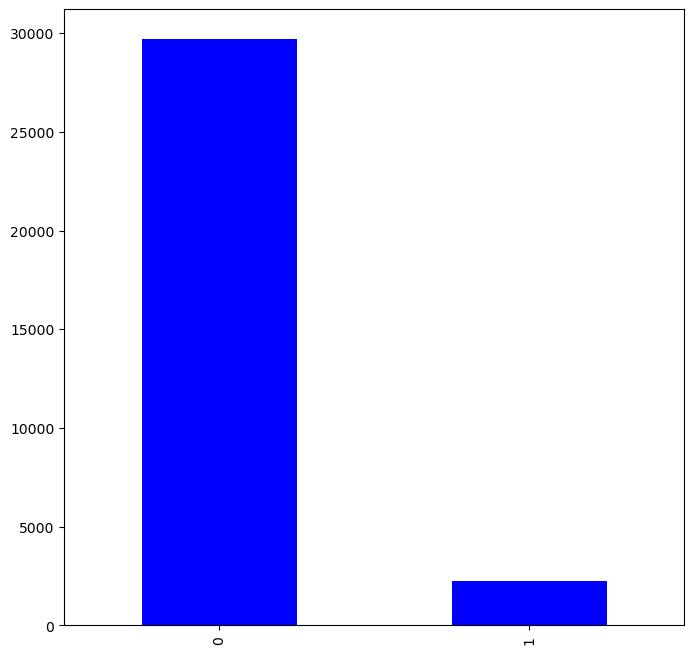

In [7]:
df['label'].value_counts().plot.bar(color = 'blue' , figsize=(8,8))

In [8]:
# from the above bar plot we see that dataset is highly imbalanced . 
#We need to do oversampling to balance the dataset in order for our classification algorithms to work better

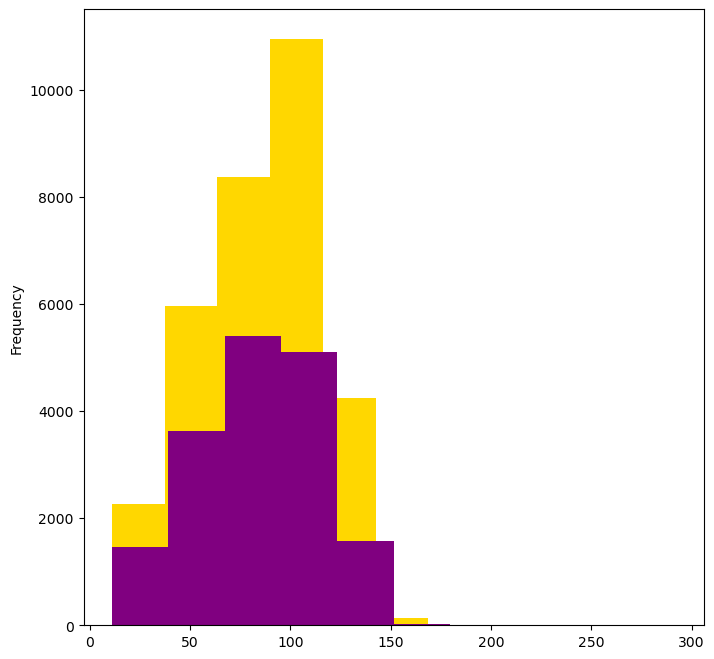

In [9]:
# checking the distribution of tweets in the data 

length_train = df['tweet'].str.len().plot.hist(color = 'gold' , figsize = (8,8))
length_test = df_test['tweet'].str.len().plot.hist(color = 'purple' , figsize = (8,8))

In [15]:
unique, counts = np.unique(df['label'], return_counts=True)

# Print the unique values and their counts
for val, count in zip(unique, counts):
    print(f"{val}: {count}")

0: 29720
1: 2242


# As we can see the above numbers are highly unbalanced , we need to oversample the dataset . 

In [16]:
import regex as re
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(df['tweet'][df['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(df['tweet'][df['label'] == 1])


In [ ]:
# # selecting top 20 most frequent hashtags     

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])


import nltk
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})


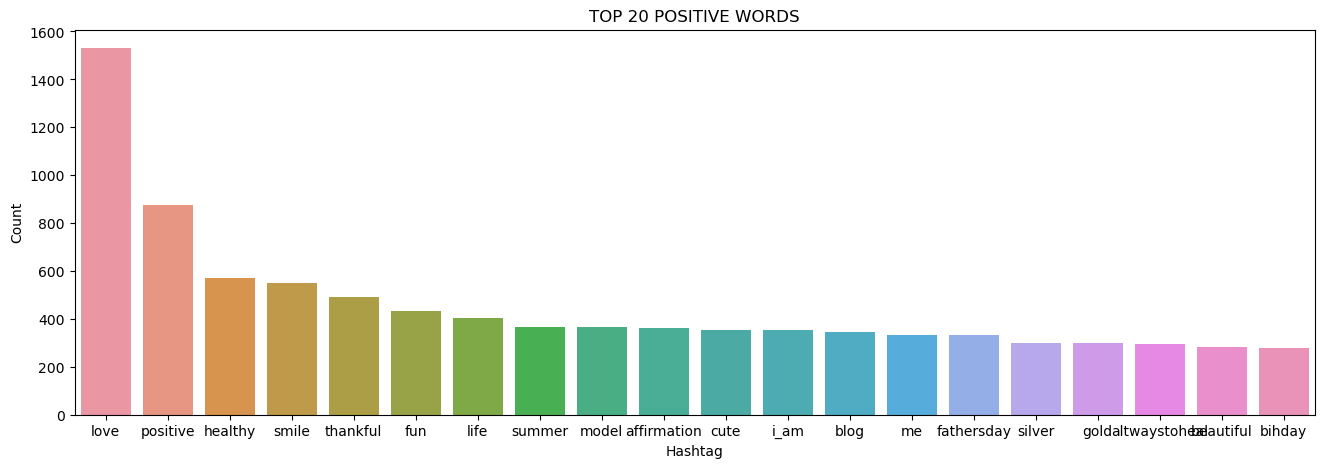

In [20]:
import seaborn as sns
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title("TOP 20 POSITIVE WORDS")
plt.show()

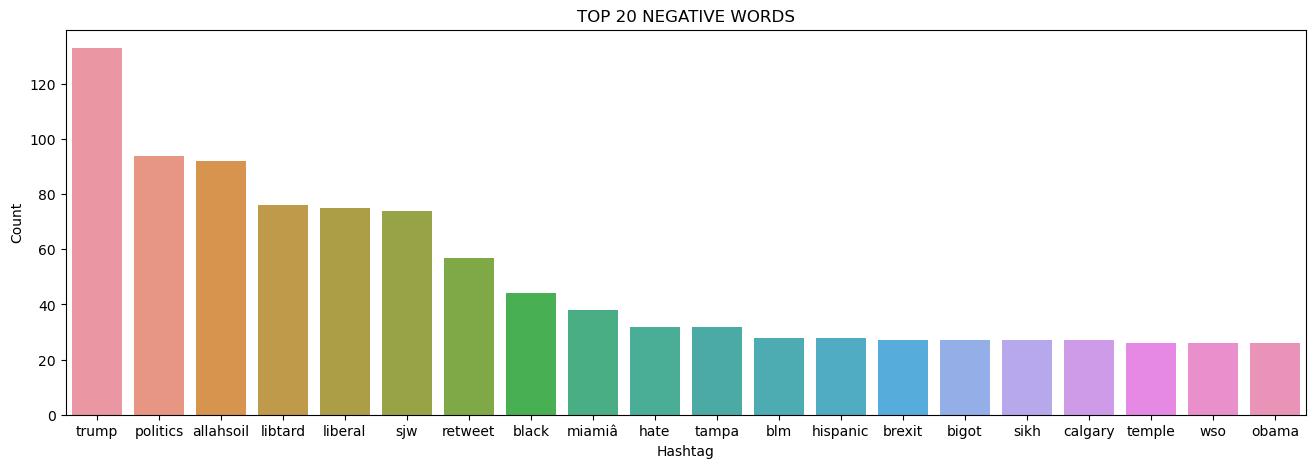

In [21]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title("TOP 20 NEGATIVE WORDS")
plt.show()

In [22]:
Y=df['label']
X=df['tweet']

In [23]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [24]:
df.shape

(31962, 3)

In [25]:
df.nunique()

id       31962
label        2
tweet    29530
dtype: int64

In [26]:
df. isnull(). sum(). sum()

0

In [9]:
# Lower case all the words of the tweet before any preprocessing
df['tweet'] = df['tweet'].str.lower()

# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so...
1,2,0,user user thanks for lyft credit i cant use ca...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in u...
4,5,0,factsguide society now motivation


In [10]:
from nltk import wsd
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
from spacy.cli import download
from spacy import load
import warnings

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
nlp = load('en_core_web_sm')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [11]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
 
        if word not in stop_words:
            lemmatizer = WordNetLemmatizer()   
            # lemmatizing changes the original word to its base/root word
            lemmatizer.lemmatize(word)
 
            imp_words.append(word)
 
    output = " ".join(imp_words)
    return output
 
 
df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,id,label,tweet
0,1,0,user father dysfunctional selfish drags kids d...
1,2,0,user user thanks lyft credit cant use cause do...
2,3,0,bihday majesty
3,4,0,model love u take u time urð± ðððð...
4,5,0,factsguide society motivation


In [31]:
df['tweet']

0        user father dysfunctional selfish drags kids d...
1        user user thanks lyft credit cant use cause do...
2                                           bihday majesty
3        model love u take u time urð± ðððð...
4                            factsguide society motivation
                               ...                        
31957    ate user isz youuuððððððð...
31958    see nina turner airwaves trying wrap mantle ge...
31959      listening sad songs monday morning otw work sad
31960    user sikh temple vandalised calgary wso condem...
31961                                    thank user follow
Name: tweet, Length: 31962, dtype: object

our dataset contains ambiguous greek symbols


In [12]:
import re

for i in range(len(df)):
    # get the comment value for the current row
    comment = df.loc[i, 'tweet']
    # clean the comment
    comment_cleaned = re.sub(r'[^\x00-\x7F]+', '', comment)
    # update the 'tweet' column for the current row with the cleaned comment
    df.loc[i, 'tweet'] = comment_cleaned


In [13]:
def generate_wordcloud(text):
    # Combine all the preprocessed text into a single string
    text = ' '.join(text)
    
    # Define the stop words
    stop_words = set(stopwords.words('english'))      #it return a list of englist stop words
    
    # Generate a word cloud from the text
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stop_words, min_font_size=10).generate(text)

    # Display the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [14]:
corpus_positive=[]
corpus_negative=[]
for i in range(len(df['tweet'])):
    if (df['label'][i]==1):
        corpus_negative.append(df['tweet'][i])
    else:
        corpus_positive.append(df['tweet'][i])


# Wordcloud for Hate speech

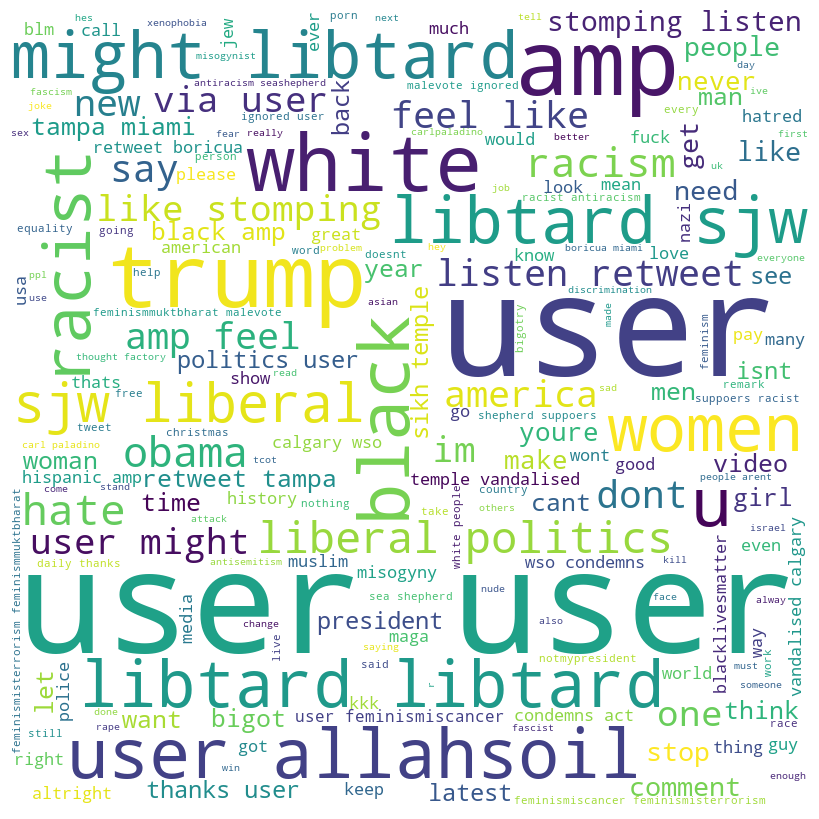

In [15]:
generate_wordcloud(corpus_negative)

# Wordcloud for Normal Speech

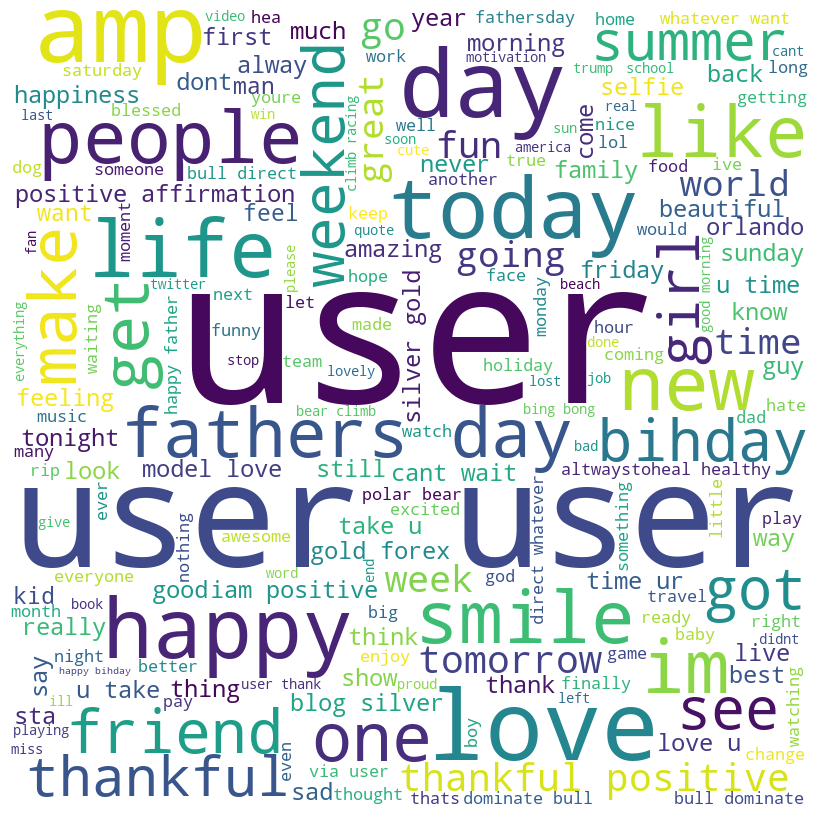

In [16]:
# Assuming that your preprocessed text is stored in a list called 'df['tweet']'
generate_wordcloud(corpus_positive)

# frequently used words in the dataset.


In [17]:
#vectorize the comments
corpus = df['tweet'].tolist()

In [18]:
corpus[0]

'user father dysfunctional selfish drags kids dysfunction run'

In [155]:
len(corpus)

31962

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [20]:
X = vectorizer.fit_transform(corpus)

In [21]:
from imblearn.over_sampling import SMOTE

# load the data into X and y
X = df['tweet']
y = df['label']

# use TF-IDF vectorizer to convert text data to numerical vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# use SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

**We oversample the unbalanced dataset using SMOTE oversampling**

# Training our Models on train.csv

In [30]:
from sklearn import svm
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets


# SVM

In [31]:
# to be implemented
# Create a SVM classifier object
clf_svm = svm.SVC()

# Train the SVM classifier on the training data
clf_svm.fit(X_resampled, y_resampled)

# Predict the labels of the test data using the trained classifier
y_pred_svm = clf_svm.predict(X_test)
# Compute the accuracy of the classifier
accuracy_svm = clf_svm.score(X_test, y_test)
print("Accuracy:", accuracy_svm)

Accuracy: 0.9599562020960426


array([0, 0, 0, ..., 0, 0, 0])

In [47]:
from sklearn.metrics import classification_report, f1_score
print("F1 Score", f1_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


F1 Score 0.6224188790560472
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5945
           1       0.92      0.47      0.62       448

    accuracy                           0.96      6393
   macro avg       0.94      0.73      0.80      6393
weighted avg       0.96      0.96      0.95      6393



**Confusion Matrix for the above model (the best model)**

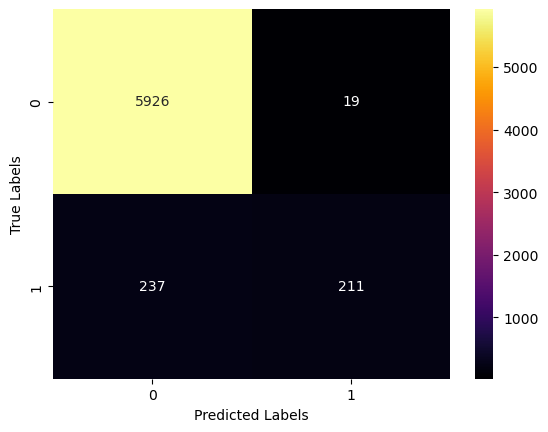

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# generate example data

# create confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, cmap='inferno', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [49]:
len(vectorizer.get_feature_names_out())

41414

In [23]:
print(X.shape)

(31962, 41414)


 # Multi Layer Perceptron

In [37]:
#applying mlp 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a MLP classifier with default parameters
mlp = MLPClassifier()

# Train the classifier on the training data
mlp.fit(X_resampled, y_resampled)

# Use the trained classifier to make predictions on the test data
y_pred_mlp = mlp.predict(X_test)

# Get unique values and their counts
unique, counts = np.unique(y_pred_mlp, return_counts=True)

# Print the unique values and their counts
for val, count in zip(unique, counts):
    print(f"{val}: {count}")

# Calculate the accuracy of the classifier
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print("Accuracy:", accuracy_mlp)

# Print a classification report showing precision, recall, f1-score, and support for each class
print(classification_report(y_test, y_pred_mlp))

0: 5764
1: 629
Accuracy: 0.9341467229782575
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5945
           1       0.52      0.73      0.61       448

    accuracy                           0.93      6393
   macro avg       0.75      0.84      0.79      6393
weighted avg       0.95      0.93      0.94      6393



# Some other models


In [22]:
import pandas as pd
acc_table = pd.DataFrame(columns = ['Model', 'Validation accuracy', 'Val F1 Score'])
def validation_scores(y_act, y_pred,name):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    #print(f'Validation Scores: Accuracy={acc}, F1-Score={f1}')
    return [name ,acc, f1]

In [23]:
# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)
y_pred_rf = rf.predict(X_test)

In [25]:
# Naive Bayes Classifier
mnb = MultinomialNB()
mnb.fit(X_resampled, y_resampled)
y_pred_NB = mnb.predict(X_test)


In [24]:
row =  [i for j in [ validation_scores(y_test, y_pred_rf,'Random Forest')] for i in j]
acc_table.loc[len(acc_table)] = row

In [35]:
row =  [i for j in [ validation_scores(y_test, y_pred_svm,'SVM')] for i in j]
acc_table.loc[len(acc_table)] = row

In [38]:
row =  [i for j in [ validation_scores(y_test, y_pred_mlp,'MLP')] for i in j]
acc_table.loc[len(acc_table)] = row

In [27]:
row = [i for j in [validation_scores(y_test, y_pred_NB,'Naive Bayes')] for i in j]
acc_table.loc[len(acc_table)] = row

**Performance of Models after OverSampling**

In [39]:
acc_table

,Model,Validation accuracy,Val F1 Score
0,Random Forest,0.962,0.686
1,Naive Bayes,0.915,0.571
2,SVM,0.960,0.622
3,MLP,0.934,0.609


# When we train SVM without oversampling

In [31]:
from sklearn import svm
from sklearn.model_selection import train_test_split

# assuming y contains the target labels
X_train, X_test, y_train, y_tests = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

clf_no_svm = svm.SVC()
clf_no_svm.fit(X_train, y_train)

y_pred_no_svm = clf_no_svm.predict(X_test)


In [27]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_tests, y_pred_no_svm)
print("Accuracy:", accuracy)

Accuracy: 0.9551071484436102


In [29]:
acc_table_2 = pd.DataFrame(columns = ['Model', 'Validation accuracy', 'Val F1 Score'])

In [32]:
row =  [i for j in [ validation_scores(y_tests, y_pred_no_svm,'SVM')] for i in j]
acc_table_2.loc[len(acc_table_2)] = row

NameError: name 'y_tests' is not defined

In [40]:
# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
row =  [i for j in [ validation_scores(y_tests, y_pred_rf,'Random Forest Classifier')] for i in j]
acc_table_2.loc[len(acc_table_2)] = row

In [42]:
# Naive Bayes Classifier
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_NB = mnb.predict(X_test)
row = [i for j in [validation_scores(y_tests, y_pred_NB,'Naive Bayes')] for i in j]
acc_table_2.loc[len(acc_table_2)] = row

In [45]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()

# Train the classifier on the training data
mlp.fit(X_train, y_train)

# Use the trained classifier to make predictions on the test data
y_pred_mlp = mlp.predict(X_test)
row = [i for j in [validation_scores(y_tests, y_pred_mlp,'MLP')] for i in j]
acc_table_2.loc[len(acc_table_2)] = row


# Performance of our model without OverSampling

In [47]:
acc_table_2

,Model,Validation accuracy,Val F1 Score
0,SVM,0.955,0.549
1,Random Forest Classifier,0.955,0.549
2,Random Forest Classifier,0.957,0.593
3,Naive Bayes,0.939,0.253
4,MLP,0.962,0.692


# ****We can see the abrupt descrease in the accuracy of the above models which defines us the importance of sampling.**

# Results of some of our trained models on Test.csv

In [165]:
#here we are pre-processing the test data just as we did while training the data.
import numpy as np
import pandas as pd
# Lower case all the words of the tweet before any preprocessing
df_test['tweet'] = df_test['tweet'].str.lower()
df_test['tweet']= df_test['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

df_test['tweet'] = df_test['tweet'].apply(lambda text: remove_stopwords(text))

import re

for i in range(len(df_test)):
    # get the comment value for the current row
    comment = df_test.loc[i, 'tweet']
    # clean the comment
    comment_cleaned = re.sub(r'[^\x00-\x7F]+', '', comment)
    # update the 'tweet' column for the current row with the cleaned comment
    df_test.loc[i, 'tweet'] = comment_cleaned

#vectorize the comments
corpus_test = df_test['tweet'].tolist()
corpus_test[0]

'studiolife aislife requires passion dedication willpower find newmaterials'

In [166]:
X_test=vectorizer.transform(corpus_test).toarray()

# SVM

In [168]:
y_pred = clf_svm.predict(X_test)

In [169]:
unique, counts = np.unique(y_pred, return_counts=True)

# Print the unique values and their counts
for val, count in zip(unique, counts):
    print(f"{val}: {count}")

0: 16386
1: 811


In [172]:
corpus=[]
for i in range(len(y_pred)):
    if (y_pred[i]==1):
        corpus.append(df_test['tweet'][i])

# Visualisation of Hate speech which was classified using SVM

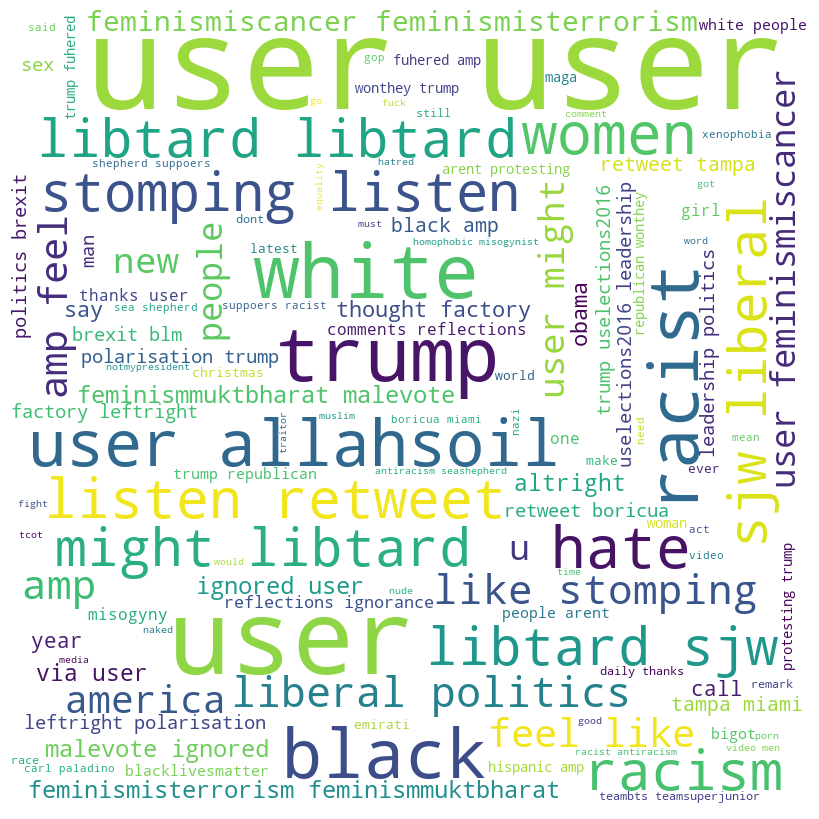

In [174]:
generate_wordcloud(corpus)

# MLP

In [199]:
y_pred = mlp.predict(X_test)

In [200]:
unique, counts = np.unique(y_pred, return_counts=True)

# Print the unique values and their counts
for val, count in zip(unique, counts):
    print(f"{val}: {count}")

0: 15383
1: 1814


In [201]:
corpus=[]
for i in range(len(y_pred)):
    if (y_pred[i]==1):
        corpus.append(df_test['tweet'][i])

# Visualisation of Hate speech which was classified using MLP

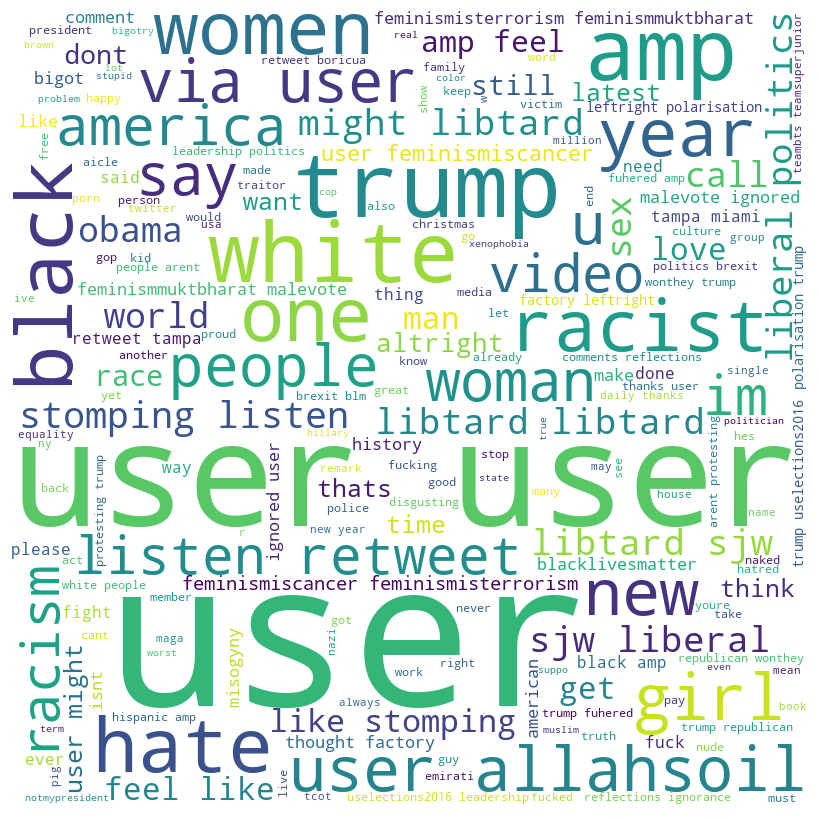

In [202]:
generate_wordcloud(corpus)

# After analysing several models and their accuracy scores , we conclude that for the dataset SVM perfomed the best . 
 We get the following scores using SVM

In [40]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5945
           1       0.92      0.47      0.62       448

    accuracy                           0.96      6393
   macro avg       0.94      0.73      0.80      6393
weighted avg       0.96      0.96      0.95      6393



**Accuracy= 0.9599562020960426**